<font size="6">PROJET 5 : Catégorisez automatiquement des questions </font>

<font size="6"> Notebook 2 : Modèles non supervisés </font>

**Librairies**

In [1]:
# Data analyse
import pandas as pd
import numpy as np
from pprint import pprint
from operator import itemgetter

In [79]:
# Visualisation
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.gensim_models
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

In [32]:
# Modèles
import gensim
import gensim.corpora as corpora
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf
from sklearn.decomposition import NMF

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer

# Evaluation
from gensim.models import CoherenceModel

**Chargement des données traités dans le Notebook 1**

In [4]:
df = pd.read_pickle("./preprocess_data.pkl")

In [5]:
df

content  \
0      is there any way to tinker with the iphone sdk...   
1      i have this gigantic ugly string j transaction...   
2      i am working with autolayout and constraints a...   
3      i m learning objective c and keep bumping into...   
4      is there a simple way in a pretty standard uni...   
...                                                  ...   
44990  recently i upgraded the version of django fram...   
44991  how can i reject a promise that returned by an...   
44992  i have entities that are related as one to man...   
44993  problemi want to return a file in my asp net w...   
44994  using suggested method this is the result a li...   

                                      preprocess_content  word_count  scala  \
0      [way, machine, plan, version, way, think, run,...          70      0   
1      [gigantic, ugly, string, transaction, start, p...         120      0   
2      [work, autolayout, constraint, find, constrain...         199      0   
3      [learn, objective, keep, bump, symbol, use, di...          48      0   
4      [simple, way, pretty, standard, unix, environm...         113      0   
...                                                  ...         ...    ...   
44990  [recently_upgrade, version, django, framework,...         331      0   
44991  [reject, promise, return, async_await, functio...          88      0   
44992  [entity, relate, manypublic, class, restaurant...         296      0   
44993  [want, return, file, web, api, controller, app...          90      0   
44994  [use, suggest, method, result, link, button, c...          71      0   

       postgresql  rest  version-control  file  npm  macos  ...  angularjs  \
0               0     0                0     0    0      0  ...          0   
1               0     0                0     0    0      0  ...          0   
2               0     0                0     0    0      0  ...          0   
3               0     0                0     0    0      0  ...          0   
4               0     0                0     0    0      0  ...          0   
...           ...   ...              ...   ...  ...    ...  ...        ...   
44990           0     0                0     0    0      0  ...          0   
44991           0     0                0     0    0      0  ...          0   
44992           0     0                0     0    0      0  ...          0   
44993           0     0                0     0    0      0  ...          0   
44994           0     0                0     0    0      0  ...          0   

       python  .net  oop  multithreading  swift  asp.net  windows  matplotlib  \
0           0     0    0               0      0        0        1           0   
1           0     0    0               0      0        0        0           0   
2           0     0    0               0      0        0        0           0   
3           0     0    0               0      0        0        0           0   
4           0     0    0               0      0        0        0           0   
...       ...   ...  ...             ...    ...      ...      ...         ...   
44990       0     0    0               0      0        0        0           0   
44991       0     0    0               0      0        0        0           0   
44992       0     0    0               0      0        0        0           0   
44993       0     0    0               0      0        0        0           0   
44994       0     0    0               0      0        0        0           0   

       linux  
0          0  
1          0  
2          0  
3          0  
4          0  
...      ...  
44990      0  
44991      0  
44992      0  
44993      0  
44994      0  

[40730 rows x 103 columns]

# Latent Dirichlet Allocation

Principes du LDA : 

## Create the dictionary and Corpus needed for topic modeling

Convert document (a list of words) into the bag-of-words format = list of (token_id, token_count) 2-tuples.

In [6]:
# Create Dictionary
id2word = corpora.Dictionary(df['preprocess_content'])
# Create Corpus
texts = df['preprocess_content']
# Term Document Frequancy
corpus = [id2word.doc2bow(text) for text in texts]

print(corpus[0])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 2), (6, 1), (7, 2), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 2), (15, 2)]


In [7]:
#Exemple de mot du dictionnaire
id2word[0]

'develop'

In [8]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('develop', 1),
  ('development', 1),
  ('image', 1),
  ('iphone', 1),
  ('legal', 1),
  ('machine', 2),
  ('plan', 1),
  ('run', 2),
  ('server', 1),
  ('sure', 1),
  ('think', 1),
  ('use', 1),
  ('version', 1),
  ('vmware', 1),
  ('way', 2),
  ('window', 2)]]

## Find the optimal number of topics for LDA?

In [9]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=dictionary,
                                                num_topics= num_topics, 
                                                random_state=100, 
                                                update_every=1,
                                                chunksize=200,
                                                passes=10,
                                                alpha='auto',
                                                per_word_topics=True)
        
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [10]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=df['preprocess_content'], 
                                                        start=3, 
                                                        limit=18, 
                                                        step=3)

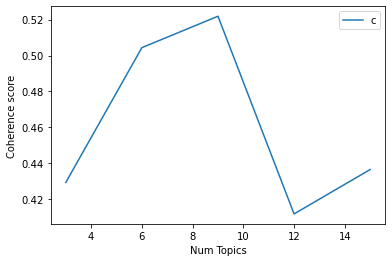

In [11]:
# Show graph
limit=18; start=3; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [12]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 3  has Coherence Value of 0.4294
Num Topics = 6  has Coherence Value of 0.5044
Num Topics = 9  has Coherence Value of 0.5219
Num Topics = 12  has Coherence Value of 0.4119
Num Topics = 15  has Coherence Value of 0.4366


In [13]:
# Select the model and print the topics
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.071*"use" + 0.021*"work" + 0.021*"way" + 0.021*"get" + 0.021*"code" + '
  '0.019*"want" + 0.016*"try" + 0.015*"find" + 0.014*"example" + 0.013*"time"'),
 (1,
  '0.061*"user" + 0.032*"json" + 0.029*"server" + 0.024*"date" + 0.021*"net" + '
  '0.021*"get" + 0.019*"web" + 0.019*"service" + 0.017*"page" + '
  '0.015*"header"'),
 (2,
  '0.094*"error" + 0.041*"com" + 0.032*"app" + 0.029*"module" + 0.028*"java" + '
  '0.022*"button" + 0.020*"log" + 0.018*"message" + 0.017*"info" + '
  '0.014*"fail"'),
 (3,
  '0.057*"android" + 0.036*"view" + 0.028*"text" + 0.027*"image" + 0.016*"d" + '
  '0.015*"css" + 0.015*"container" + 0.015*"class" + 0.012*"activity" + '
  '0.011*"width"'),
 (4,
  '0.046*"change" + 0.033*"git" + 0.021*"remove" + 0.019*"repository" + '
  '0.019*"add" + 0.017*"branch" + 0.016*"style" + 0.016*"node" + '
  '0.015*"commit" + 0.014*"update"'),
 (5,
  '0.073*"file" + 0.032*"run" + 0.025*"project" + 0.023*"version" + '
  '0.018*"build" + 0.017*"command" + 0.015*"line" +

**Compute Model Perplexity and Coherence Score**

In [14]:
# Compute Perplexity
print('\nPerplexity: ', optimal_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=optimal_model, texts=df['preprocess_content'], dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.135120226434276

Coherence Score:  0.5218514029730107


## Visualize the topics-keywords

In [15]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(optimal_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.205195 -0.084055       1        1  26.713834
6     -0.113260 -0.036488       2        1  13.678914
5      0.184307  0.020944       3        1  13.345598
7     -0.231418 -0.142304       4        1  10.049945
2      0.217886 -0.153781       5        1   8.178831
3     -0.142022 -0.028149       6        1   7.908901
4      0.045325  0.389738       7        1   7.557015
1      0.018753 -0.027187       8        1   6.835821
8     -0.184766  0.061283       9        1   5.731140, topic_info=           Term          Freq         Total Category  logprob  loglift
11          use  38356.000000  38356.000000  Default  30.0000  30.0000
68         file  19598.000000  19598.000000  Default  29.0000  29.0000
313       error  15560.000000  15560.000000  Default  28.0000  28.0000
2051       quot  15974.000000  15974.000000  Default  27.0000  27.0000
46       string  15224.000000  15224.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
62       create   1783.793859   9599.546828   Topic9  -4.1708   1.1763
385   statement    822.114720   1402.840623   Topic9  -4.9454   2.3249
738      update   1037.111866   4429.185525   Topic9  -4.7131   1.4075
34         name    988.140921  11697.261910   Topic9  -4.7615   0.3880
301        null    836.229719   3256.811085   Topic9  -4.9284   1.4997

[436 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
52        1  0.999576    able
177       2  0.327090  access
177       5  0.089539  access
177       8  0.576701  access
177       9  0.006213  access
...     ...       ...     ...
97        7  0.041546    work
155       1  0.997140   write
155       2  0.000933   write
155       3  0.001866   write
1138      8  0.999118    year

[589 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 7, 6, 8, 3, 4, 5, 2, 9])

**Word Cloud of Top N words in each topic**

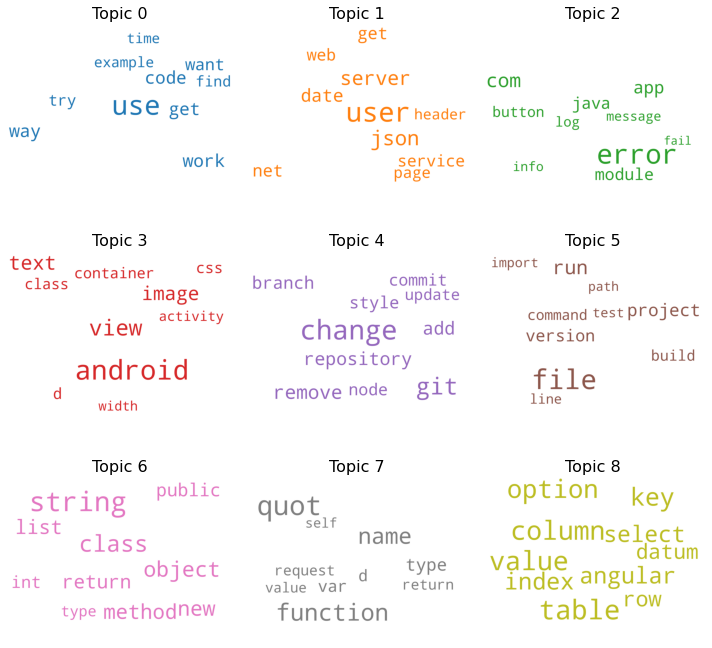

In [84]:
#Wordcloud of Top N words in each topic
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = optimal_model.show_topics(formatted=False)

fig, axes = plt.subplots(3, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## Finding the dominant topic in each sentence

In [16]:
def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=df['preprocess_content']):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [17]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=df['preprocess_content'])

In [18]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0             5.0              0.3861   
1            1             0.0              0.4890   
2            2             3.0              0.2800   
3            3             0.0              0.4119   
4            4             5.0              0.4751   
5            5             0.0              0.5355   
6            6             0.0              0.6624   
7            7             1.0              0.2875   
8            8             2.0              0.4783   
9            9             6.0              0.6219   

                                            Keywords  \
0  file, run, project, version, build, command, l...   
1  use, work, way, get, code, want, try, find, ex...   
2  android, view, text, image, d, css, container,...   
3  use, work, way, get, code, want, try, find, ex...   
4  file, run, project, version, build, command, l...   
5  use, work, way, get, code, want, try, find, ex...   
6  use, work, way, get, code, want, try, find, ex...   
7  user, json, server, date, net, get, web, servi...   
8  error, com, app, module, java, button, log, me...   
9  string, class, object, new, method, list, retu...   

                                                Text  
0  [way, machine, plan, version, way, think, run,...  
1  [gigantic, ugly, string, transaction, start, p...  
2  [work, autolayout, constraint, find, constrain...  
3  [learn, objective, keep, bump, symbol, use, di...  
4  [simple, way, pretty, standard, unix, environm...  
5  [write, java, utility, generate, load, datum, ...  
6  [need, find, format, number, string, code, ret...  
7  [local, access, server, way, duplicate, clone,...  
8  [best_practice, consider, catch, exception, th...  
9  [give, class, like, trace, functionality, log,...

## Find the most representative document for each topic

In [19]:
# Group top 5 sentences under each topic
sent_topics_sorteddf = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                    grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)],
                                   axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf

Topic_Num  Topic_Perc_Contrib  \
0        0.0              0.8477   
1        1.0              0.6203   
2        2.0              0.7086   
3        3.0              0.8483   
4        4.0              0.7464   
5        5.0              0.7854   
6        6.0              0.8170   
7        7.0              0.7965   
8        8.0              0.7120   

                                            Keywords  \
0  use, work, way, get, code, want, try, find, ex...   
1  user, json, server, date, net, get, web, servi...   
2  error, com, app, module, java, button, log, me...   
3  android, view, text, image, d, css, container,...   
4  change, git, remove, repository, add, branch, ...   
5  file, run, project, version, build, command, l...   
6  string, class, object, new, method, list, retu...   
7  quot, function, name, type, var, d, return, re...   
8  table, value, column, option, key, index, angu...   

                                                Text  
0  [suppose, file, contain, ip_addresse, address,...  
1  [please_explain, difference, css, class, synta...  
2  [use, fair, comfortable, structure, amp, query...  
3  [want, initialize, string, java, string, need,...  
4                                                NaN  
5                                                NaN  
6  [week, break, expand, extend, knowlege, templa...  
7  [seem, impossible, make, cache, limit, number,...  
8  [know, negate, need, regular_expression, negat...

**Topic distribution across documents**

In [20]:
df_dominant_topics = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']].groupby(['Dominant_Topic', 'Topic_Keywords'])['Topic_Keywords'].count().reset_index(name='Num_Documents')

df_dominant_topics['Perc_Documents'] = (df_dominant_topics['Num_Documents'])/(df_dominant_topics['Num_Documents'].sum())

df_dominant_topics

Dominant_Topic                                     Topic_Keywords  \
0             0.0  use, work, way, get, code, want, try, find, ex...   
1             1.0  user, json, server, date, net, get, web, servi...   
2             2.0  error, com, app, module, java, button, log, me...   
3             3.0  android, view, text, image, d, css, container,...   
4             4.0  change, git, remove, repository, add, branch, ...   
5             5.0  file, run, project, version, build, command, l...   
6             6.0  string, class, object, new, method, list, retu...   
7             7.0  quot, function, name, type, var, d, return, re...   
8             8.0  table, value, column, option, key, index, angu...   

   Num_Documents  Perc_Documents  
0          20608        0.505966  
1           1093        0.026835  
2           1195        0.029340  
3           2586        0.063491  
4           1508        0.037024  
5           4776        0.117260  
6           4901        0.120329  
7           2544        0.062460  
8           1519        0.037294

# Non-Negative Matrix Factorization

Principes de la NMF : 

In [21]:
def top_words(topic, n_top_words):
    return topic.argsort()[:-n_top_words - 1:-1]  


def topic_table(model, feature_names, n_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        t = (topic_idx)
        topics[t] = [feature_names[i] for i in top_words(topic, n_top_words)]
    return pd.DataFrame(topics)


def whitespace_tokenizer(text): 
    pattern = r"(?u)\b\w\w+\b" 
    tokenizer_regex = RegexpTokenizer(pattern)
    tokens = tokenizer_regex.tokenize(text)
    return tokens


In [22]:
# Use Gensim's NMF to get the best num of topics via coherence score
texts = df['preprocess_content']

# Create a dictionary
# In gensim a dictionary is a mapping between words and their integer id
dictionary = Dictionary(texts)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(
    no_below=3,
    no_above=0.85,
    keep_n=5000
)

# Create the bag-of-words format (list of (token_id, token_count))
corpus = [dictionary.doc2bow(text) for text in texts]

# Create a list of the topic numbers we want to try
topic_nums = list(np.arange(3, 18, 3))

# Run the nmf model and calculate the coherence score
# for each number of topics
coherence_scores = []

for num in topic_nums:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )
    
    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(cm.get_coherence(), 5))

In [23]:
# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

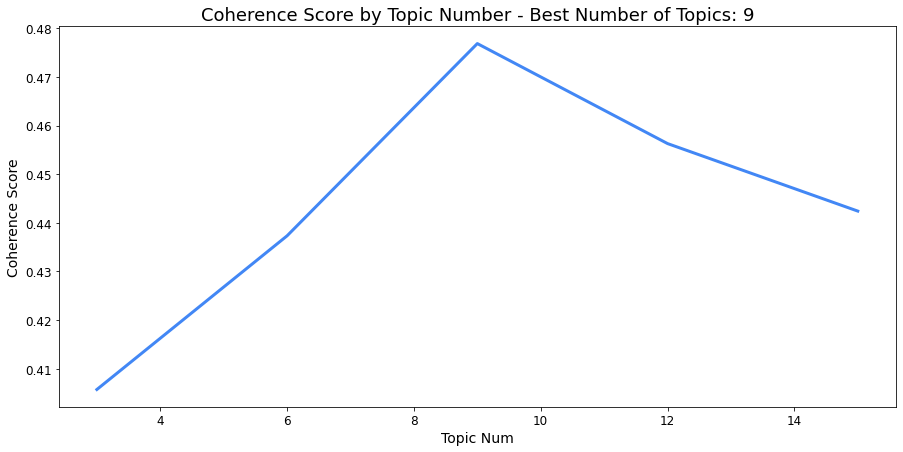

In [24]:
# Plot the results
fig = plt.figure(figsize=(15, 7))

plt.plot(
    topic_nums,
    coherence_scores,
    linewidth=3,
    color='#4287f5'
)

plt.xlabel("Topic Num", fontsize=14)
plt.ylabel("Coherence Score", fontsize=14)
plt.title('Coherence Score by Topic Number - Best Number of Topics: {}'.format(best_num_topics), fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [88]:
texts

0        [way, machine, plan, version, way, think, run,...
1        [gigantic, ugly, string, transaction, start, p...
2        [work, autolayout, constraint, find, constrain...
3        [learn, objective, keep, bump, symbol, use, di...
4        [simple, way, pretty, standard, unix, environm...
                               ...                        
44990    [recently_upgrade, version, django, framework,...
44991    [reject, promise, return, async_await, functio...
44992    [entity, relate, manypublic, class, restaurant...
44993    [want, return, file, web, api, controller, app...
44994    [use, suggest, method, result, link, button, c...
Name: preprocess_content, Length: 40730, dtype: object

In [33]:
# Now use the number of topics with the highest coherence score to run the sklearn nmf model

# Create the tfidf weights
tfidf_vectorizer = TfidfVectorizer(
    min_df=3,
    max_df=0.85,
    max_features=5000,
    ngram_range=(1, 2),
    preprocessor=' '.join)

tfidf = tfidf_vectorizer.fit_transform(texts)

# Save the feature names for later to create topic summaries
tfidf_fn = tfidf_vectorizer.get_feature_names()

# Run the nmf model
nmf = NMF(
    n_components=best_num_topics,
    init='nndsvd',
    max_iter=500,
    l1_ratio=0.0,
    solver='cd',
    alpha=0.0,
    tol=1e-4,
    random_state=42).fit(tfidf)

In [34]:
# Use the top words for each cluster by tfidf weight to create 'topics'

# Funtion to remove duplicate words
def unique_words(text): 
    ulist = []
    [ulist.append(x) for x in text if x not in ulist]
    return ulist


# Getting a df with each topic by document
docweights = nmf.transform(tfidf_vectorizer.transform(texts))

n_top_words = 10

topic_df = topic_table(
    nmf,
    tfidf_fn,
    n_top_words).T

# Cleaning up the top words to create topic summaries
topic_df['topics'] = topic_df.apply(lambda x: [' '.join(x)], axis=1) # Joining each word into a list
topic_df['topics'] = topic_df['topics'].str[0]  # Removing the list brackets
topic_df['topics'] = topic_df['topics'].apply(lambda x: whitespace_tokenizer(x)) # tokenize
topic_df['topics'] = topic_df['topics'].apply(lambda x: unique_words(x))  # Removing duplicate words
topic_df['topics'] = topic_df['topics'].apply(lambda x: [' '.join(x)])  # Joining each word into a list
topic_df['topics'] = topic_df['topics'].str[0]  # Removing the list brackets

topic_df

0          1          2              3            4      5          6  \
0     use      class   function          error       method   code        get   
1    file       line  directory        command       folder   path       open   
2  string    convert  character  string string       format    int     number   
3    quot  quot quot  name quot     class quot         json   name  type quot   
4     git     branch     commit     repository       remote   push     change   
5   table     column        row          value       select  query       name   
6   array      value    element         object  array array  numpy        key   
7   image    android       text         button          css   view      input   
8    list       item  list list        element         sort    way   new list   

                7           8           9  \
0          object      return  difference   
1         project      script         run   
2  convert string       value     replace   
3       file quot   quot name  quot class   
4           merge      master        pull   
5        database        date       datum   
6        function  javascript       index   
7         element        page       style   
8             new   item list       index   

                                              topics  
0  use class function error method code get objec...  
1  file line directory command folder path open p...  
2  string convert character format int number val...  
3                     quot name class json type file  
4  git branch commit repository remote push chang...  
5  table column row value select query name datab...  
6  array value element object numpy key function ...  
7  image android text button css view input eleme...  
8               list item element sort way new index

In [35]:
# Create a df with only the created topics and topic num
topic_df = topic_df['topics'].reset_index()
topic_df.columns = ['topic_num', 'topics']

topic_df

topic_num                                             topics
0          0  use class function error method code get objec...
1          1  file line directory command folder path open p...
2          2  string convert character format int number val...
3          3                     quot name class json type file
4          4  git branch commit repository remote push chang...
5          5  table column row value select query name datab...
6          6  array value element object numpy key function ...
7          7  image android text button css view input eleme...
8          8               list item element sort way new index

# Prédiction à partir d'un modèle non supervisé

## Split en train et test test

In [53]:
df3 = df[['content', 'preprocess_content']]  
# 75% random du dataset pour le train
dftrain = df3.sample(frac = 0.75)

# 25% restant pour la prédiction sur data inconnue
dftest = df.drop(dftrain.index).reset_index().drop(columns = 'index')

dftrain = dftrain.reset_index().drop(columns = 'index')

In [54]:
dftrain

content  \
0      i am using an ng repeat directive with filter ...   
1      can someone show me how to get the youtube id ...   
2      i m a regular expression newbie and i can t qu...   
3      i m working on a site that uses basic authenti...   
4      let s say that you want to output or concat st...   
...                                                  ...   
30543  i came across this line of ruby code what does...   
30544  i want to set the background image of a div in...   
30545  so now that html introduces history pushstate ...   
30546  i ve been trying to get my head around getters...   
30547  is it possible to place a screenshot in readme...   

                                      preprocess_content  
0      [use, ng_repeat, directive, filter, ng_repeat,...  
1      [show, get, regardless, get, variable, url, us...  
2      [regular_expression, newbie, quite, figure, wr...  
3      [work, site, use, use, chrome, log, use, remov...  
4      [let_say, want, output, concat, string, follow...  
...                                                  ...  
30543  [came_across, line, ruby, code, amp, mean, obj...  
30544  [set, background, image, div, component, templ...  
30545  [introduce, history, pushstate, change, browse...  
30546  [try, get, head_around, getters_setter, sink, ...  
30547  [possible, place, screenshot, readme, file, gi...  

[30548 rows x 2 columns]

## Entrainement du modèle

In [55]:
# Create the tfidf weights
tfidf_vectorizer = TfidfVectorizer(
    min_df=3,
    max_df=0.85,
    max_features=5000,
    ngram_range=(1, 2),
    preprocessor=' '.join)

tfidf = tfidf_vectorizer.fit_transform(dftrain['preprocess_content'])

# Save the feature names for later to create topic summaries
tfidf_fn = tfidf_vectorizer.get_feature_names()

# Run the nmf model
nmf = NMF(
    n_components=best_num_topics,
    init='nndsvd',
    max_iter=500,
    l1_ratio=0.0,
    solver='cd',
    alpha=0.0,
    tol=1e-4,
    random_state=42).fit(tfidf)

nmf

NMF(init='nndsvd', max_iter=500, n_components=9, random_state=42)

## Prédiction sur le test set (données inconnue du modèle)

In [63]:
# Transform the new data with the fitted models
tfidf_new = tfidf_vectorizer.transform(dftest['preprocess_content'])
X_new = nmf.transform(tfidf_new)

# Get the top predicted topic
predicted_topics = [np.argsort(each)[::-1][0] for each in X_new]

# Add to the df
dftest['topic_num'] = predicted_topics

dftest = dftest[['content', 'preprocess_content', 'topic_num']]
dftest

content  \
0      i m learning objective c and keep bumping into...   
1      is there a simple way in a pretty standard uni...   
2      without local access to the server is there an...   
3      what are the best practices to consider when c...   
4      i am trying to insert into a table using the i...   
...                                                  ...   
10177  after the latest update of php intelephense th...   
10178  seems pretty googleable but haven t been able ...   
10179  i m starting to play with the create react app...   
10180  recently i upgraded the version of django fram...   
10181  using suggested method this is the result a li...   

                                      preprocess_content  topic_num  
0      [learn, objective, keep, bump, symbol, use, di...          2  
1      [simple, way, pretty, standard, unix, environm...          1  
2      [local, access, server, way, duplicate, clone,...          5  
3      [best_practice, consider, catch, exception, th...          0  
4      [try, insert, table, use, input, table, entire...          5  
...                                                  ...        ...  
10177  [late, update, php, intelephense, get, today, ...          0  
10178  [seem, pretty, googleable, able, find, online,...          0  
10179  [start, play, create, react, app, index, load,...          3  
10180  [recently_upgrade, version, django, framework,...          1  
10181  [use, suggest, method, result, link, button, c...          7  

[10182 rows x 3 columns]

In [57]:
# Getting a df with each topic by document
docweights = nmf.transform(tfidf_vectorizer.transform(dftrain['preprocess_content']))

n_top_words = 10

topic_df = topic_table(
    nmf,
    tfidf_fn,
    n_top_words).T

# Cleaning up the top words to create topic summaries
topic_df['topics'] = topic_df.apply(lambda x: [' '.join(x)], axis=1) # Joining each word into a list
topic_df['topics'] = topic_df['topics'].str[0]  # Removing the list brackets
topic_df['topics'] = topic_df['topics'].apply(lambda x: whitespace_tokenizer(x)) # tokenize
topic_df['topics'] = topic_df['topics'].apply(lambda x: unique_words(x))  # Removing duplicate words
topic_df['topics'] = topic_df['topics'].apply(lambda x: [' '.join(x)])  # Joining each word into a list
topic_df['topics'] = topic_df['topics'].str[0]  # Removing the list brackets

# Create a df with only the created topics and topic num
topic_df = topic_df['topics'].reset_index()
topic_df.columns = ['topic_num', 'topics']

topic_df

topic_num                                             topics
0          0  use class function error method code get objec...
1          1  file line directory command folder path open r...
2          2  string convert character format replace number...
3          3                     quot name json class type file
4          4  git branch commit repository remote push chang...
5          5  table column row value select query name datab...
6          6  array value element object function numpy key ...
7          7  android image text button css view element inp...
8          8        list item element sort new value way object

In [76]:
# Join with the original df to get the topic summary
dfpred = pd.merge(dftest, topic_df, on='topic_num', how='left')

dfpred

content  \
0      i m learning objective c and keep bumping into...   
1      is there a simple way in a pretty standard uni...   
2      without local access to the server is there an...   
3      what are the best practices to consider when c...   
4      i am trying to insert into a table using the i...   
...                                                  ...   
10177  after the latest update of php intelephense th...   
10178  seems pretty googleable but haven t been able ...   
10179  i m starting to play with the create react app...   
10180  recently i upgraded the version of django fram...   
10181  using suggested method this is the result a li...   

                                      preprocess_content  topic_num  \
0      [learn, objective, keep, bump, symbol, use, di...          2   
1      [simple, way, pretty, standard, unix, environm...          1   
2      [local, access, server, way, duplicate, clone,...          5   
3      [best_practice, consider, catch, exception, th...          0   
4      [try, insert, table, use, input, table, entire...          5   
...                                                  ...        ...   
10177  [late, update, php, intelephense, get, today, ...          0   
10178  [seem, pretty, googleable, able, find, online,...          0   
10179  [start, play, create, react, app, index, load,...          3   
10180  [recently_upgrade, version, django, framework,...          1   
10181  [use, suggest, method, result, link, button, c...          7   

                                                  topics  
0      string convert character format replace number...  
1      file line directory command folder path open r...  
2      table column row value select query name datab...  
3      use class function error method code get objec...  
4      table column row value select query name datab...  
...                                                  ...  
10177  use class function error method code get objec...  
10178  use class function error method code get objec...  
10179                     quot name json class type file  
10180  file line directory command folder path open r...  
10181  android image text button css view element inp...  

[10182 rows x 4 columns]